In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib

In [2]:
y = pd.read_csv('data/农副产品_周度数据_2021-12-02')
y = y[y['品种']=='大带鱼']
y['时间'] = pd.to_datetime(y['时间'])
y = y.set_index('时间').sort_index(ascending=True)
y = y['环比']
y = y[1:]
y = y.map(lambda x: float(x[:-1]))
y = y.apply(lambda x: 1 if x>=0 else 0)
y

时间
2006-07-14    0
2006-07-21    1
2006-07-28    1
2006-08-04    1
2006-08-11    0
             ..
2021-10-29    0
2021-11-05    0
2021-11-12    1
2021-11-19    0
2021-11-26    1
Name: 环比, Length: 799, dtype: int64

In [3]:
X = pd.read_csv('data/生产资料_周度监测数据_2021-12-02')
X['时间'] = pd.to_datetime(X['时间'])
X['环比'] = X['环比'].map(lambda x: float(x[:-1] if pd.notna(x) else x))
X = X.pivot_table(values='环比', index='时间', columns='品种')
X = X.dropna()
X

品种,丁苯橡胶,三元复合肥,二号无烟块煤,冷轧普通薄板,动力煤,国产标准胶,复合水泥(42.5),尿素,工字钢,无缝钢管,...,焊接钢管,螺纹钢,进口3号烟片胶,铜(1#),铝(A00),锌(1#),锡(1#),镀锌板,镍(1#),顺丁橡胶
时间,,,,,,,,,,,,,,,,,,,,,
2016-09-23,1.97,-0.28,0.53,0.14,0.61,3.92,0.00,-0.13,-1.24,-0.09,...,-0.79,-0.73,3.02,1.78,1.47,2.04,1.44,-0.03,4.03,2.88
2016-09-30,1.12,-0.04,0.66,0.06,1.01,-0.39,1.00,0.07,0.00,0.18,...,-0.17,0.23,0.28,0.97,2.36,1.11,2.27,0.28,1.22,2.64
2016-10-07,0.84,-0.08,0.26,0.26,0.80,0.20,0.66,-0.07,-0.14,0.30,...,0.17,0.15,0.03,-0.30,0.35,-0.38,-0.01,0.38,-1.76,1.59
2016-10-14,5.28,-0.24,0.39,1.29,0.80,2.65,2.63,0.00,0.77,0.77,...,0.86,1.04,2.85,0.28,0.38,-1.11,0.67,0.61,0.92,7.20
2016-10-21,-0.24,0.04,0.91,2.17,0.99,0.00,0.64,0.33,1.01,2.13,...,1.32,2.14,0.18,-0.95,-0.79,1.44,0.33,0.96,-1.07,-0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29,1.04,1.12,-1.16,-1.09,-3.05,0.03,1.13,1.28,-1.05,-0.45,...,-0.71,-3.50,1.19,-3.97,-11.43,-6.17,-3.35,-1.30,-2.43,0.79
2021-11-05,1.28,0.81,-5.02,-1.60,-5.27,-0.81,-0.19,-2.57,-1.72,-1.13,...,-1.35,-3.19,-0.08,0.23,-1.07,0.02,3.65,-0.98,-1.69,1.76
2021-11-12,-0.05,0.03,-0.52,-3.54,-3.50,-0.85,0.37,-1.12,-2.31,-2.38,...,-2.31,-4.00,-0.94,-0.70,-5.93,-1.42,0.63,-2.70,0.72,-0.30


In [4]:
y0 = y.reindex(index=pd.date_range(start='2016-09-23', end='2021-11-26', freq='7D'))
y0[y0.isna()]
# 去网站上看了一下，原数据还真是缺的

2019-10-04   NaN
2021-02-12   NaN
Name: 环比, dtype: float64

In [6]:
X0 = X.reindex(index=pd.date_range(start='2016-09-23', end='2021-11-26', freq='7D'))
X0['尿素'][X0['尿素'].isna()]
# 尿素这几天也的确是缺的

2018-01-26   NaN
2018-11-16   NaN
2018-11-30   NaN
2019-10-04   NaN
2020-01-24   NaN
2021-02-12   NaN
Name: 尿素, dtype: float64

In [6]:
data = pd.merge(X, y, on='时间')
data

,丁苯橡胶,三元复合肥,二号无烟块煤,冷轧普通薄板,动力煤,国产标准胶,复合水泥(42.5),尿素,工字钢,无缝钢管,...,螺纹钢,进口3号烟片胶,铜(1#),铝(A00),锌(1#),锡(1#),镀锌板,镍(1#),顺丁橡胶,环比
时间,,,,,,,,,,,,,,,,,,,,,
2016-09-23,1.97,-0.28,0.53,0.14,0.61,3.92,0.00,-0.13,-1.24,-0.09,...,-0.73,3.02,1.78,1.47,2.04,1.44,-0.03,4.03,2.88,1
2016-09-30,1.12,-0.04,0.66,0.06,1.01,-0.39,1.00,0.07,0.00,0.18,...,0.23,0.28,0.97,2.36,1.11,2.27,0.28,1.22,2.64,1
2016-10-07,0.84,-0.08,0.26,0.26,0.80,0.20,0.66,-0.07,-0.14,0.30,...,0.15,0.03,-0.30,0.35,-0.38,-0.01,0.38,-1.76,1.59,0
2016-10-14,5.28,-0.24,0.39,1.29,0.80,2.65,2.63,0.00,0.77,0.77,...,1.04,2.85,0.28,0.38,-1.11,0.67,0.61,0.92,7.20,1
2016-10-21,-0.24,0.04,0.91,2.17,0.99,0.00,0.64,0.33,1.01,2.13,...,2.14,0.18,-0.95,-0.79,1.44,0.33,0.96,-1.07,-0.63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29,1.04,1.12,-1.16,-1.09,-3.05,0.03,1.13,1.28,-1.05,-0.45,...,-3.50,1.19,-3.97,-11.43,-6.17,-3.35,-1.30,-2.43,0.79,0
2021-11-05,1.28,0.81,-5.02,-1.60,-5.27,-0.81,-0.19,-2.57,-1.72,-1.13,...,-3.19,-0.08,0.23,-1.07,0.02,3.65,-0.98,-1.69,1.76,0
2021-11-12,-0.05,0.03,-0.52,-3.54,-3.50,-0.85,0.37,-1.12,-2.31,-2.38,...,-4.00,-0.94,-0.70,-5.93,-1.42,0.63,-2.70,0.72,-0.30,1


In [7]:
dtrain = xgb.DMatrix(data=data.iloc[:-66, :-1], label=data.iloc[1:-65, -1])
dtest = xgb.DMatrix(data=data.iloc[-66:-1, :-1], label=data.iloc[-65:, -1])

In [8]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

[19:59:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
preds

array([0.32577407, 0.5057208 , 0.32577407, 0.32577407, 0.28579578,
       0.48689857, 0.708138  , 0.32577407, 0.708138  , 0.32577407,
       0.32577407, 0.32577407, 0.32577407, 0.5886417 , 0.5886417 ,
       0.21877562, 0.8745764 , 0.5886417 , 0.701893  , 0.48689857,
       0.87783355, 0.48689857, 0.87783355, 0.48689857, 0.87783355,
       0.5886417 , 0.8745764 , 0.21877562, 0.5886417 , 0.58440995,
       0.32577407, 0.701893  , 0.701893  , 0.5886417 , 0.32577407,
       0.32577407, 0.701893  , 0.701893  , 0.87783355, 0.48689857,
       0.32577407, 0.28579578, 0.7518678 , 0.48689857, 0.58440995,
       0.32577407, 0.32577407, 0.32577407, 0.32577407, 0.5057208 ,
       0.708138  , 0.48689857, 0.708138  , 0.708138  , 0.5886417 ,
       0.7518678 , 0.5057208 , 0.5057208 , 0.5886417 , 0.58440995,
       0.87783355, 0.58440995, 0.48689857, 0.28579578, 0.48689857],
      dtype=float32)

In [10]:
preds1 = pd.Series(preds)
preds1.apply(round)

0     0
1     1
2     0
3     0
4     0
     ..
60    1
61    1
62    0
63    0
64    0
Length: 65, dtype: int64

In [11]:
test_y = data.iloc[-65:, -1].reset_index(drop=True)
test_y

0     1
1     0
2     0
3     0
4     1
     ..
60    0
61    0
62    1
63    0
64    1
Name: 环比, Length: 65, dtype: int64

In [12]:
(preds1.apply(round) == test_y).value_counts()

False    35
True     30
dtype: int64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

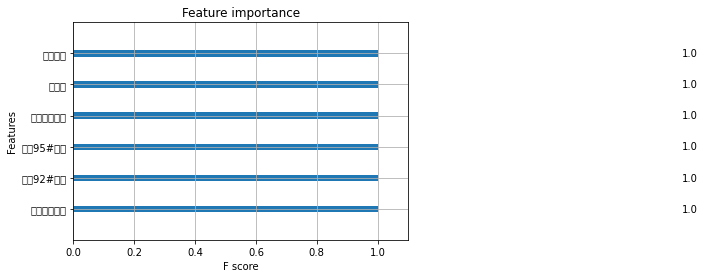

In [14]:
xgb.plot_importance(bst)